In [ ]:
# ruff: noqa
import jax
jax.config.update("jax_enable_x64", True)
from typing import Callable

import astropy.constants as const
import astropy.units as u
import jax.numpy as jnp
from astropy.coordinates import SkyCoord
from astropy.time import Time

from numpy.polynomial import chebyshev as C
import matplotlib.pyplot as plt

from jorbit import Ephemeris

In [2]:
@jax.jit
def eval_cheby(coefficients: jnp.ndarray, x: float) -> tuple:
    """Evaluates a Chebyshev polynomial using Clenshaw's algorithm.

    Implements Clenshaw's recurrence formula for evaluating Chebyshev polynomials
    in a numerically stable way.

    Args:
        coefficients (jnp.ndarray): Chebyshev polynomial coefficients.
        x (float): Input value in the domain [-1, 1].

    Returns:
        tuple:
            A tuple containing (jnp.ndarray, The evaluated polynomial value;
            jnp.ndarray, Intermediate values used for velocity computation).
    """
    b_ii = jnp.zeros(1)
    b_i = jnp.zeros(1)

    def scan_func(X: tuple, a: jnp.ndarray) -> tuple:
        b_i, b_ii = X
        tmp = b_i
        b_i = a + 2 * x * b_i - b_ii
        b_ii = tmp
        return (b_i, b_ii), b_i

    (b_i, b_ii), s = jax.lax.scan(scan_func, (b_i, b_ii), coefficients[:-1])
    return coefficients[-1] + x * b_i - b_ii, s

Degree 6 worst fit: obj 4 dim 0

Degree 7 worst fit: obj 9 dim 0

Degree 8 worst fit: obj 10 dim 1

Degree 9 worst fit: obj 9 dim 0



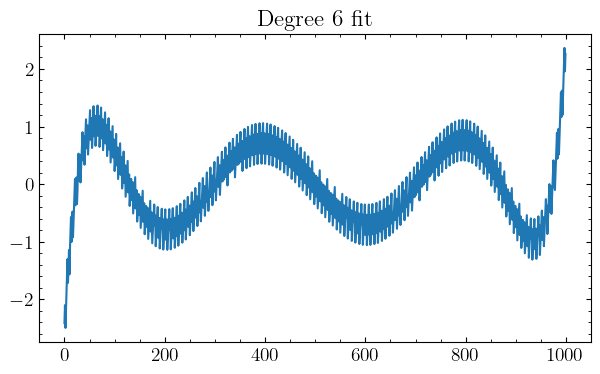

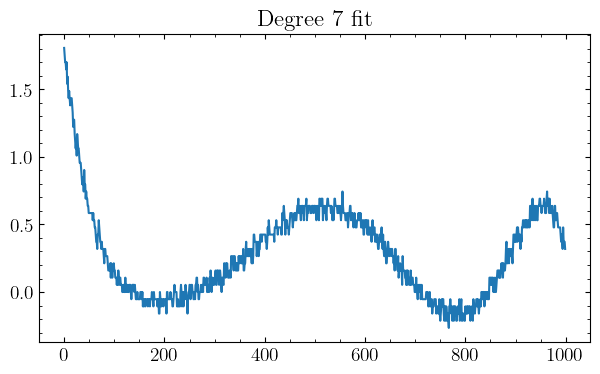

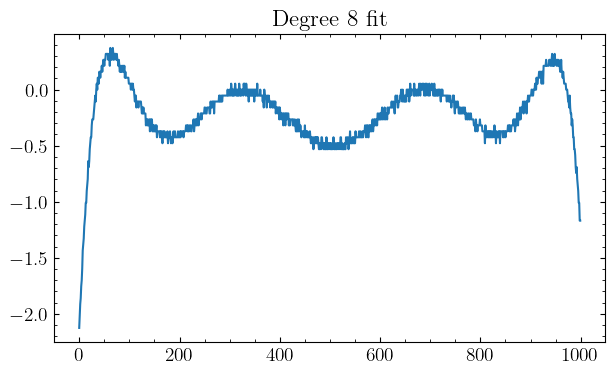

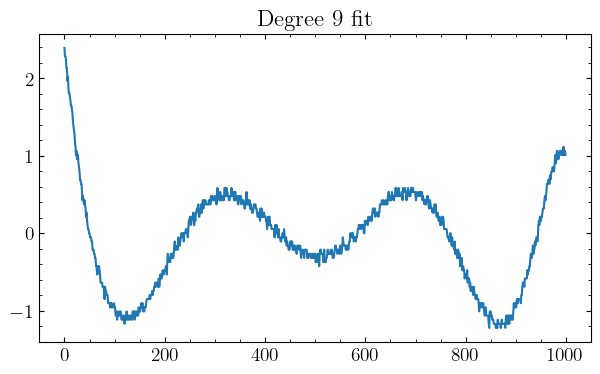

<Figure size 711.1x400 with 0 Axes>

In [30]:
eph = Ephemeris()
times = Time("2020-01-01") + jnp.linspace(-((250*u.au) / const.c).to(u.day).value, 0.1, 1000) * u.day
actual_xs, actual_vs = jax.vmap(eph.processor.state)(times.tdb.jd)


t = times.tdb.jd
t0, t1 = t[0], t[-1]
x = 2*(t - t0)/(t1 - t0) - 1

for deg in range(6,10):
    worst_score = 0
    worst_obj = jnp.nan
    worst_dim = jnp.nan
    for obj in range(actual_xs.shape[1]):
        for dim in range(3):
            points = actual_xs[:,obj,dim]
            cheb = C.Chebyshev.fit(x, points, deg)
            coeffs = jnp.array(cheb.coef)
            err = points - jax.vmap(lambda t: eval_cheby(coeffs[::-1], t)[0])(x)[:,0]
            if jnp.max(jnp.abs(err)) > worst_score:
                # print(f"Degree {deg} obj {obj} dim {dim} max err {jnp.max(jnp.abs(err))}")
                worst_score = jnp.max(jnp.abs(err))
                worst_obj = obj
                worst_dim = dim

    print(f"Degree {deg} worst fit: obj {worst_obj} dim {worst_dim}")
    print()
    points = actual_xs[:,worst_obj,worst_dim]
    cheb = C.Chebyshev.fit(x, points, deg)
    coeffs = jnp.array(cheb.coef)
    plt.plot((points - jax.vmap(lambda t: eval_cheby(coeffs[::-1], t)[0])(x)[:,0])*u.au.to(u.cm))
    plt.title(f"Degree {deg} fit")
    plt.figure()